In [1]:
%matplotlib inline

In [69]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import gc

# from sklearn import svm, decomposition
from preprocess import remove_high_freq, whitening, from_cifar_to_np, from_submit_to_np
from plot import imshow
from util import trainNN, cal_accuracy, cal_class_accuracy, get_submit_result, export_to_file, print_accracy
from models import *

use_pca = False
use_forieum = False
export_csv = True
csv_name = 'res_resnet_big_batch.csv'
BATCH_SIZE = 32

In [70]:
print('==> Preparing data..')
transform_train = transforms.Compose(
    [
#          transforms.RandomRotation(5),
         transforms.RandomCrop(32, padding=4),
#          transforms.RandomResizedCrop(32),
         transforms.RandomHorizontalFlip(),
#          transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
         remove_high_freq
    ]) if use_forieum else transforms.Compose(
    [
#          transforms.RandomRotation(5),
         transforms.RandomCrop(32, padding=4),
#          transforms.RandomResizedCrop(32),
         transforms.RandomHorizontalFlip(),
#          transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]) 

transform_test = transforms.Compose(
    [
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
         remove_high_freq
    ]) if use_forieum else transforms.Compose(
    [
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]) 


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=0)
submitdata = np.load("./test/y_test.npy").astype(np.uint8)

submit_images = [ transform_test(img) for img in submitdata]

submitloader = torch.utils.data.DataLoader(submit_images, batch_size=3000,
                                          shuffle=False, num_workers=2)

# class MyDataset(torch.utils.data.Dataset):
#     def __init__(self,testdata,transform):
#         # show image
#         self.testdata=testdata
#         self.len = testdata.shape[0]
#         self.transform=transform

#     def __getitem__(self, index):
#         img = self.transform(self.testdata[index])
#         return img

#     def __len__(self):
#         return self.len

# submitset = MyDataset(testdata=submitdata, transform=transform_test)
# submitloader = torch.utils.data.DataLoader(submitset, batch_size=1, shuffle=False, num_workers=0)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [4]:
trainX, trainY = from_cifar_to_np(trainloader)
if not use_forieum:
    trainX = np.reshape(trainX, (50000, 3072))
print(trainX.shape)
print(trainY.shape)

(50000, 3072)
(50000,)


In [5]:
testX, testY = from_cifar_to_np(testloader)
if not use_forieum:
    testX = np.reshape(testX, (10000, 3072))
print(testX.shape)
print(testY.shape)

(10000, 3072)
(10000,)


In [6]:
submitX = from_submit_to_np(submitloader)
if not use_forieum:
    submitX = np.reshape(submitX, (12000, 3072))
print(submitX.shape)

(12000, 3072)


In [7]:
# Assume that we are on a CUDA machine, then this should print a CUDA device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


torch.Size([128, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse   dog   car   cat truck   dog  ship  bird


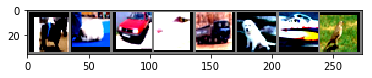

In [8]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# print(images)
print(images.size())

# show images in a batch, which contains 8 images
imshow(torchvision.utils.make_grid(images[0:8]))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [9]:
print('==> Building model..')
# net = SeventySevenNet()
# net = ResNet18()
# net = LargeNet()
net = VGG('VGG19')
# net = WeakerNet21()
net = net.to(device)
criterion = nn.CrossEntropyLoss()

==> Building model..


In [10]:
for i in range(15): 
    optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4)
    trainNN(net, trainloader, optimizer, criterion,  1)
    print('Accuracy of the network on the 10000 test images: %f %%' % (
        100 * cal_accuracy(net, testloader)))
    print('Accuracy of the network on the train images: %f %%' % (
        100 * cal_accuracy(net, trainloader)))

Training starts
[1,   100] double loss: 0.0236375
[1,   200] double loss: 0.0182681
[1,   300] double loss: 0.0180407
Accuracy of the network on the 10000 test images: 12.450000 %
Accuracy of the network on the train images: 12.528000 %
Training starts
[1,   100] double loss: 0.0175818
[1,   200] double loss: 0.0171437
[1,   300] double loss: 0.0164462
Accuracy of the network on the 10000 test images: 22.320000 %
Accuracy of the network on the train images: 22.598000 %
Training starts
[1,   100] double loss: 0.0150487
[1,   200] double loss: 0.0148103
[1,   300] double loss: 0.0144287
Accuracy of the network on the 10000 test images: 29.040000 %
Accuracy of the network on the train images: 29.106000 %
Training starts
[1,   100] double loss: 0.0139216
[1,   200] double loss: 0.0135255
[1,   300] double loss: 0.0130410
Accuracy of the network on the 10000 test images: 36.810000 %
Accuracy of the network on the train images: 38.044000 %
Training starts
[1,   100] double loss: 0.0121908
[1

In [11]:
for i in range(10): 
    optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9, weight_decay=5e-4)
    trainNN(net, trainloader, optimizer, criterion,  1)
    print('Accuracy of the network on the 10000 test images: %f %%' % (
        100 * cal_accuracy(net, testloader)))
    print('Accuracy of the network on the train images: %f %%' % (
        100 * cal_accuracy(net, trainloader)))

Training starts
[1,   100] double loss: 0.0034982
[1,   200] double loss: 0.0031399
[1,   300] double loss: 0.0028568
Accuracy of the network on the 10000 test images: 84.660000 %
Accuracy of the network on the train images: 88.602000 %
Training starts
[1,   100] double loss: 0.0027024
[1,   200] double loss: 0.0026622
[1,   300] double loss: 0.0027304
Accuracy of the network on the 10000 test images: 85.730000 %
Accuracy of the network on the train images: 89.658000 %
Training starts
[1,   100] double loss: 0.0024801
[1,   200] double loss: 0.0024789
[1,   300] double loss: 0.0024303
Accuracy of the network on the 10000 test images: 86.100000 %
Accuracy of the network on the train images: 90.298000 %
Training starts
[1,   100] double loss: 0.0022867
[1,   200] double loss: 0.0023067
[1,   300] double loss: 0.0023391
Accuracy of the network on the 10000 test images: 86.590000 %
Accuracy of the network on the train images: 91.162000 %
Training starts
[1,   100] double loss: 0.0020568
[1

In [12]:
for i in range(10): 
    optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-2)
    trainNN(net, trainloader, optimizer, criterion,  1)
    print('Accuracy of the network on the 10000 test images: %f %%' % (
        100 * cal_accuracy(net, testloader)))
    print('Accuracy of the network on the train images: %f %%' % (
        100 * cal_accuracy(net, trainloader)))

Training starts
[1,   100] double loss: 0.0014415
[1,   200] double loss: 0.0013806
[1,   300] double loss: 0.0014201
Accuracy of the network on the 10000 test images: 88.200000 %
Accuracy of the network on the train images: 94.650000 %
Training starts
[1,   100] double loss: 0.0013196
[1,   200] double loss: 0.0013075
[1,   300] double loss: 0.0012244
Accuracy of the network on the 10000 test images: 88.250000 %
Accuracy of the network on the train images: 94.786000 %
Training starts
[1,   100] double loss: 0.0012677
[1,   200] double loss: 0.0012741
[1,   300] double loss: 0.0012459
Accuracy of the network on the 10000 test images: 88.520000 %
Accuracy of the network on the train images: 95.166000 %
Training starts
[1,   100] double loss: 0.0011962
[1,   200] double loss: 0.0012355
[1,   300] double loss: 0.0012898
Accuracy of the network on the 10000 test images: 88.410000 %
Accuracy of the network on the train images: 95.156000 %
Training starts
[1,   100] double loss: 0.0011766
[1

In [55]:
for i in range(10): 
    optimizer = optim.SGD(net.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-2)
    trainNN(net, trainloader, optimizer, criterion,  1)
    print('Accuracy of the network on the 10000 test images: %f %%' % (
        100 * cal_accuracy(net, testloader)))
    print('Accuracy of the network on the train images: %f %%' % (
        100 * cal_accuracy(net, trainloader)))

Training starts
[1,   100] double loss: 0.0010835
[1,   200] double loss: 0.0010988
[1,   300] double loss: 0.0010807
Accuracy of the network on the 10000 test images: 88.320000 %
Accuracy of the network on the train images: 96.224000 %
Training starts
[1,   100] double loss: 0.0010811
[1,   200] double loss: 0.0010761
[1,   300] double loss: 0.0010364
Accuracy of the network on the 10000 test images: 88.480000 %
Accuracy of the network on the train images: 96.162000 %
Training starts
[1,   100] double loss: 0.0010764
[1,   200] double loss: 0.0010641
[1,   300] double loss: 0.0010125
Accuracy of the network on the 10000 test images: 88.570000 %
Accuracy of the network on the train images: 96.352000 %
Training starts
[1,   100] double loss: 0.0010251
[1,   200] double loss: 0.0010229
[1,   300] double loss: 0.0010575
Accuracy of the network on the 10000 test images: 88.490000 %
Accuracy of the network on the train images: 96.152000 %
Training starts
[1,   100] double loss: 0.0010938
[1

In [71]:
for i in range(3): 
    optimizer = optim.SGD(net.parameters(), lr=1e-5, momentum=0.9, weight_decay=1e-2)
    trainNN(net, trainloader, optimizer, criterion,  5)
    print('Accuracy of the network on the 10000 test images: %f %%' % (
        100 * cal_accuracy(net, testloader)))
    print('Accuracy of the network on the train images: %f %%' % (
        100 * cal_accuracy(net, trainloader)))

Training starts
[1,   100] double loss: 0.0009798
[1,   200] double loss: 0.0009832
[1,   300] double loss: 0.0010066
[2,   100] double loss: 0.0009772
[2,   200] double loss: 0.0009841
[2,   300] double loss: 0.0009236
[3,   100] double loss: 0.0009602
[3,   200] double loss: 0.0010207
[3,   300] double loss: 0.0010227
[4,   100] double loss: 0.0009752
[4,   200] double loss: 0.0009661
[4,   300] double loss: 0.0010351
[5,   100] double loss: 0.0009892
[5,   200] double loss: 0.0009742
[5,   300] double loss: 0.0010465
Accuracy of the network on the 10000 test images: 88.520000 %
Accuracy of the network on the train images: 96.358000 %
Training starts
[1,   100] double loss: 0.0009773
[1,   200] double loss: 0.0009930
[1,   300] double loss: 0.0009997
[2,   100] double loss: 0.0009749
[2,   200] double loss: 0.0010340
[2,   300] double loss: 0.0009955
[3,   100] double loss: 0.0009490
[3,   200] double loss: 0.0010103
[3,   300] double loss: 0.0010110
[4,   100] double loss: 0.0010149

In [72]:
params = list(net.parameters())
print(len(params))

66


In [73]:
cal_class_accuracy(net, testloader)

Accuracy of plane : 88 %
Accuracy of   car : 96 %
Accuracy of  bird : 76 %
Accuracy of   cat : 90 %
Accuracy of  deer : 93 %
Accuracy of   dog : 81 %
Accuracy of  frog : 94 %
Accuracy of horse : 87 %
Accuracy of  ship : 97 %
Accuracy of truck : 93 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


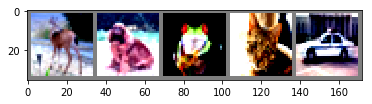

In [74]:
images = submit_images[2100:2105]
imshow(torchvision.utils.make_grid(images))

(3000, 3, 32, 32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


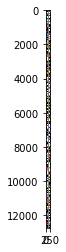

In [75]:
dataiter = iter(submitloader)
images = dataiter.next()
print(np.array(images).shape)
imshow(torchvision.utils.make_grid(images))

In [76]:
gc.collect()

2005

In [77]:
# res_labels = get_submit_result(net, submitloader)
res_per = []
with torch.no_grad():
    for i, data in enumerate(submitloader, 0):
        inputs = data.to(device)
        # forward + backward + optimize
        outputs = net(inputs)
        for o in outputs:
            res_per.append(o)
res_labels = [int(torch.max(t,0)[1]) for t in res_per]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane plane plane plane plane plane  ship   cat  ship plane plane plane  ship plane plane plane plane  deer plane truck plane plane plane plane plane plane plane plane plane truck


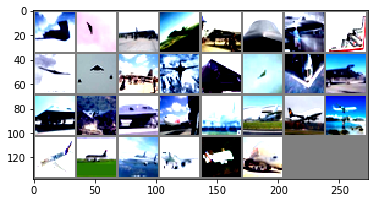

In [78]:
images = submit_images[0:30]
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[res_labels[j]] for j in range(0, 30)))

In [79]:
if export_csv:
    export_to_file(csv_name, res_labels)